---
# (1) Short-Time Fourier Transform (STFT) & Chromagram (I): Sine wave
Let's investigate the STFT. Topics:

*   *librosa* library (https://librosa.org/doc/latest/index.html)
*   Analysis of our sine wave using STFT and Chromagram
*   Playground for parameters

In [ ]:
import librosa
import librosa.display
import numpy as np


### Create an (mag-)STFT from the sine wave
stft_sine = np.abs(librosa.stft(y=sine_wave, n_fft=1024, hop_length=1024, win_length=None, window='hann', center=True, pad_mode='reflect'))
stft_sine_db = librosa.amplitude_to_db(stft_sine, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(stft_sine_db, y_axis='log', x_axis='time', ax=ax)
ax.set(title='Power spectrogram')
#plt.colorbar(img, ax=ax, format="%+2.0f dB")
plt.plot()


### Create a chromagram from the STFT. Check the librosa doc!
chroma = librosa.feature.chroma_stft(S=stft_sine, sr=22050)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram')
#plt.colorbar(img, ax=ax)
plt.plot()

---
# (2) Short-Time Fourier Transform (STFT) & Chromagram (II): Piano chords
Topics in this section:
*   Get to know the STFT-spectrogram
*   Spectrum analysis of piano overtones, in comparison to the sine wave
*   Behaviour of Chromagram for notes over several octaves

[]

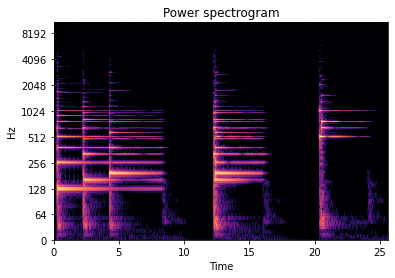

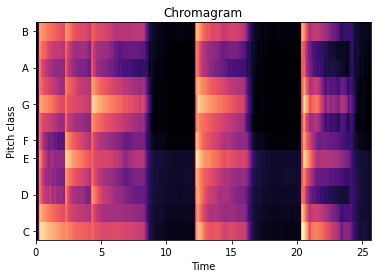

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd


### Example audio: Load 'Piano1-1.wav' using librosa. It has a sample rate of 44100. Convert it to mono.
piano_data, piano_sr = librosa.load('Piano1-1.wav', sr=44100, mono=True)


### Turn into STFT, then db, then plot
piano_stft = np.abs(librosa.stft(piano_data, n_fft=4096, hop_length=512, window='hann', center=True, pad_mode='reflect'))
piano_stft_db = librosa.amplitude_to_db(piano_stft, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(piano_stft_db, y_axis='log', x_axis='time', ax=ax)
ax.set(title='Power spectrogram')
#plt.colorbar(img, ax=ax, format="%+2.0f dB")
plt.plot()


### Turn the STFT into a chromagram, then db, then plot
chroma_stft = librosa.feature.chroma_stft(S=piano_stft, sr=piano_sr, norm=None)
chroma_stft_db = librosa.amplitude_to_db(chroma_stft, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_stft_db, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram')
#plt.colorbar(img, ax=ax)
plt.plot()

Expected output:

*   1st note block: [C E G] in succession, but overlapping
*   2nd note block: [E G C+1 E+1] simultaneously
*   3rd note block: [C E G C+1] simultaneously
*   Chromagram: notice the same notes from different octaves are grouped together



---
# (3) Mel-Spectrogram
The Mel-Spectrogram is based on the Mel scale, a perceptual scale of the pitches. Topics in this section:

*   Using the piano audio, create a Mel-spectrogram with 128 bands and a f_max of 8000
*   Analyse the difference to an STFT-spectrogram

[]

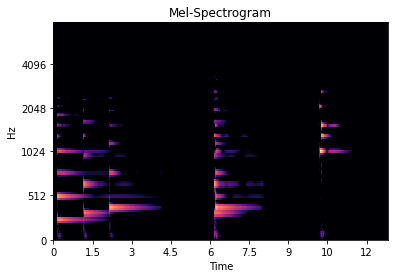

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


### Create the Mel-spectrogram, then convert it from power to dB
piano_mel = np.abs(librosa.feature.melspectrogram(y=piano_data, sr=44100, n_mels=128, fmax=8000))
piano_mel_dB = librosa.amplitude_to_db(piano_mel, ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(piano_mel_dB, x_axis='time', y_axis='mel', sr=44100, fmax=8000, ax=ax)  # FILL IN: librosa's specshow()
ax.set(title='Mel-Spectrogram')
#plt.colorbar(img, ax=ax, format="%+2.0f dB")
plt.plot()

---
# (Coming up) **Building a sound classification system** - First steps
---

# ESC-50 dataset
*   https://github.com/karolpiczak/ESC-50
*   Dataset for Environmental Sound Classification
*   We choose 5 classes, and 2 should be very similar to each other

In the next AST seminar, we will use these things to build our own first simple sound classification system.



